In [3]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../../scripts/")
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from trajectory import Trajectory, load_trajectory_dict
from hivevo.patients import Patient
import filenames
import copy
from activity import get_average_activity
from proba_fix import get_proba_fix

# Activity plots

## Functions

Format of the dictionnaries : trajectories[region][rev/non_rev/syn/non_syn]

In [4]:
def get_mean_in_time(trajectories, nb_bins=20, freq_range=[0.4, 0.6]):
    """
    Computes the mean frequency in time of a set of trajectories from the point they are seen in the freq_range window.
    Returns the middle of the time bins and the computed frequency mean.
    """
    trajectories = copy.deepcopy(trajectories)
    
    # Create bins and select trajectories going through the freq_range
    time_bins = np.linspace(-677, 3000, nb_bins)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]

    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    t_traj = np.array([])
    f_traj = np.array([])
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        t_traj = np.concatenate((t_traj, traj.t))
        f_traj = np.concatenate((f_traj, traj.frequencies))

    # Binning of all the data in the time bins
    filtered_fixed = [traj for traj in trajectories if traj.fixation == "fixed"]
    filtered_lost = [traj for traj in trajectories if traj.fixation == "lost"]
    freqs, fixed, lost = [], [], []
    for ii in range(len(time_bins) - 1):
        freqs = freqs + [f_traj[np.logical_and(t_traj >= time_bins[ii], t_traj < time_bins[ii + 1])]]
        fixed = fixed + [len([traj for traj in filtered_fixed if traj.t[-1] < time_bins[ii]])]
        lost = lost + [len([traj for traj in filtered_lost if traj.t[-1] < time_bins[ii]])]

    # Computation of the mean in each bin, active trajectories contribute their current frequency,
    # fixed contribute 1 and lost contribute 0
    mean = []
    for ii in range(len(freqs)):
        mean = mean + [np.sum(freqs[ii]) + fixed[ii]]
        mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])

    nb_active = [len(freq) for freq in freqs]
    nb_dead = [fixed[ii] + lost[ii] for ii in range(len(fixed))]

    return 0.5 * (time_bins[1:] + time_bins[:-1]), mean, nb_active, nb_dead
    
    
    
def make_mean_in_time_dict(trajectories):
    regions = ["env", "pol", "gag", "all"]
    means = {}
    freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
    times = []

    for freq_range in freq_ranges:
        means[str(freq_range)] = {}
        for region in regions:
            means[str(freq_range)][region] = {}
            for key in trajectories[region].keys():
                times, means[str(freq_range)][region][key], _, _ = get_mean_in_time(trajectories[region][key], freq_range=freq_range)
    return times, means, freq_ranges

def make_pfix(nb_bin=8):
    regions = ["env", "pol", "gag", "all"]
    pfix = {}
    for region in regions:
        pfix[region] = {}
        for key in trajectories[region].keys():
            tmp_freq_bin, tmp_proba, tmp_err = get_proba_fix(trajectories[region][key], nb_bin=nb_bin)
            pfix[region][key] = {"freq_bin": tmp_freq_bin, "proba": tmp_proba, "error": tmp_err}
    return pfix

def get_trajectories_offset(trajectories, freq_range):
    trajectories = copy.deepcopy(trajectories)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]
    
    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        if traj.fixation == "fixed":
            traj.t = np.append(traj.t, [traj.t[-1]+300, 3000])
            traj.frequencies = np.append(traj.frequencies, [1,1])
        elif traj.fixation == "lost":
            traj.t = np.append(traj.t, [traj.t[-1]+300, 3000])
            traj.frequencies = np.append(traj.frequencies, [0,0])
        
    return trajectories

## Mean in time

In [5]:
trajectories = load_trajectory_dict("../../trajectory_dict")
times, means, freq_ranges = make_mean_in_time_dict(trajectories)
trajectories_scheme = get_trajectories_offset(trajectories["all"]["rev"], [0.4, 0.6])

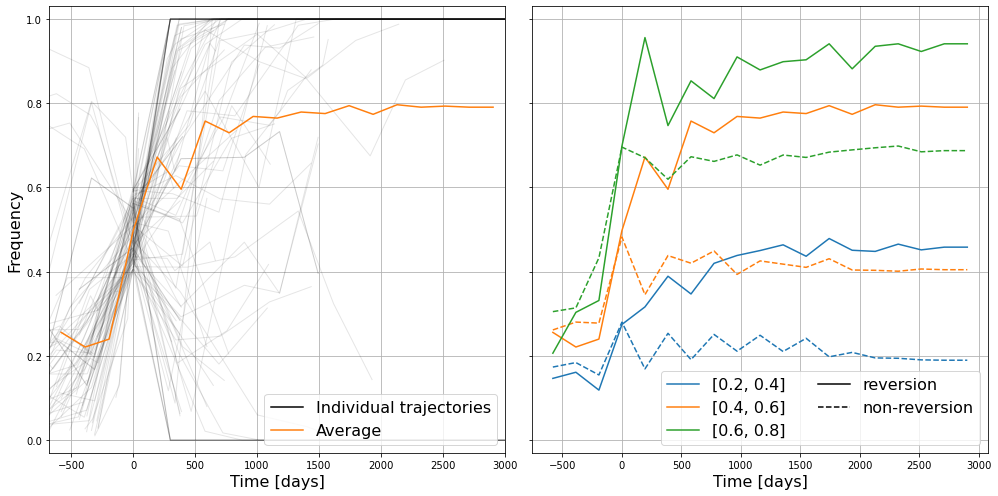

In [5]:
fontsize=16
grid_alpha = 0.5
colors = ["C0","C1","C2","C4"]
markersize=12
freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
regions = ["env","pol","gag"]
lines = ["-","--"]


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,7), sharey=True)


# Plot left

for traj in trajectories_scheme:
    axs[0].plot(traj.t, traj.frequencies, "k-", alpha=0.1, linewidth=1)
    
axs[0].plot(times, means["[0.4, 0.6]"]["all"]["rev"], '-', color=colors[1])
    
axs[0].set_xlabel("Time [days]", fontsize=fontsize)
axs[0].set_ylabel("Frequency", fontsize=fontsize)
axs[0].set_ylim([-0.03, 1.03])
axs[0].grid(grid_alpha)
axs[0].set_xlim([-677, 3000])

line1, = axs[0].plot([0], [0], "k-")
line2, = axs[0].plot([0], [0], "-", color=colors[1])
axs[0].legend([line1, line2], ["Individual trajectories", "Average"], fontsize=fontsize, loc="lower right")


# Plot right
for ii, freq_range in enumerate(freq_ranges):
    axs[1].plot(times, means[str(freq_range)]["all"]["rev"], "-", color=colors[ii])
    axs[1].plot(times, means[str(freq_range)]["all"]["non_rev"], "--", color=colors[ii])
        
line1, = axs[1].plot([0], [0], "k-")
line2, = axs[1].plot([0], [0], "k--")
line3, = axs[1].plot([0], [0], "-", color=colors[0])
line4, = axs[1].plot([0], [0], "-", color=colors[1])
line5, = axs[1].plot([0], [0], "-", color=colors[2])

axs[1].set_xlabel("Time [days]", fontsize=fontsize)
# axs[1].set_ylabel("Frequency", fontsize=fontsize)
axs[1].set_ylim([-0.03, 1.03])
axs[1].grid(grid_alpha)
axs[1].legend([line3, line4, line5, line1, line2], ["[0.2, 0.4]", "[0.4, 0.6]", "[0.6, 0.8]", "reversion", "non-reversion"], fontsize=fontsize, ncol=2, loc="lower right")

plt.tight_layout()
plt.savefig("Reversion_PAC.png", format="png")
plt.show()

In [7]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../../scripts/")
import matplotlib.pyplot as plt
import numpy as np

from WH_prediction import *

In [8]:
evo_rates = {"pol": {"consensus": {"first": 1.98e-6, "second": 1.18e-6, "third": 5.96e-6},
                     "non_consensus": {"first": 2.88e-5, "second": 4.549e-5, "third": 2.06e-5}}}
equilibrium_frequency = {"pol": {"first": 0.952, "second": 0.975, "third": 0.860}}

colors = ["C0","C1","C2"]
regions = ["pol"]
fontsize = 16
figsize = (7, 5)

for pos in ["first","second","third"]:
    evo_rates["pol"]["consensus"][pos] = (1.98e-6 +1.18e-6 + 5.96e-6)/3
    evo_rates["pol"]["non_consensus"][pos] = (2.88e-5 + 4.549e-5 + 2.06e-5)/3

In [9]:
def get_theory(rate_non_rev, rate_rev, time):
    saturation = rate_non_rev / (rate_rev + rate_non_rev) /3
    tau = 1 / (rate_rev + rate_non_rev)
    theory = saturation * (1 - np.exp(-time / tau))
    return theory

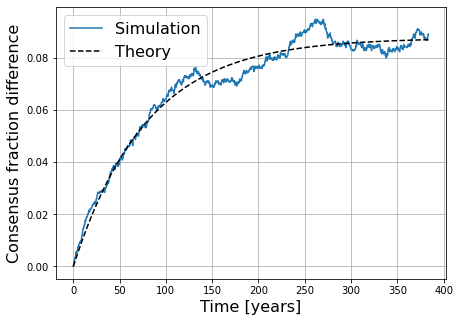

In [10]:
nb_simulation = 1
simulation_time = 140000  # in days
dt = 10
time = np.arange(0, simulation_time+1, dt)
sampling_time = 10 * dt
sequence_length = 2500


plt.figure(figsize=figsize)
for ii, region in enumerate(regions):
    # True is consensus, False is non consensus
    x_0 = np.ones(sequence_length, dtype=bool)
    sequences = run_simulation_group(x_0, simulation_time, dt, evo_rates[region], sampling_time, nb_simulation)
    
    distance_initial = distance_to_initial(sequences)
    mean_distance_initial = np.mean(distance_initial, axis=-1)
    fraction_difference = mean_distance_initial / sequence_length
    
    rate_rev = 1/3*(evo_rates["pol"]["non_consensus"]["first"]+evo_rates["pol"]["non_consensus"]["second"]+evo_rates["pol"]["non_consensus"]["third"])
    rate_non_rev = 1/3*(evo_rates["pol"]["consensus"]["first"]+evo_rates["pol"]["consensus"]["second"]+evo_rates["pol"]["consensus"]["third"])

    x = time[::10] / 365
    theory1 = get_theory(evo_rates["pol"]["consensus"]["first"], evo_rates["pol"]["non_consensus"]["first"], time) 
    theory2 = get_theory(evo_rates["pol"]["consensus"]["second"], evo_rates["pol"]["non_consensus"]["second"], time) 
    theory3 = get_theory(evo_rates["pol"]["consensus"]["third"], evo_rates["pol"]["non_consensus"]["third"], time) 
    
    plt.plot(x, fraction_difference, label="Simulation", color=colors[ii])
    plt.plot(time/365, theory1+theory2+theory3, 'k--', label="Theory")
    
plt.xlabel("Time [years]", fontsize=fontsize)
plt.ylabel("Consensus fraction difference", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid()
plt.savefig("Evo_rate.png", format="png")
plt.show()

In [6]:
def make_activity_dict(trajectories, min_freq=0.0, normalize=True):
    regions = ["env", "pol", "gag"]
    activities = {}
    for region in regions:
        tmp_dict = {}
        for traj_type in ["rev", "non_rev", "syn", "non_syn", "all"]:
            tmp_traj = [traj for traj in trajectories[region][traj_type] if np.sum(traj.frequencies>min_freq, dtype=bool)]
            tmp_dict[traj_type] = get_average_activity(tmp_traj, True)
        activities[region] = tmp_dict

    time_bins = activities["env"]["rev"]["time_bins"]
    
    return time_bins, activities

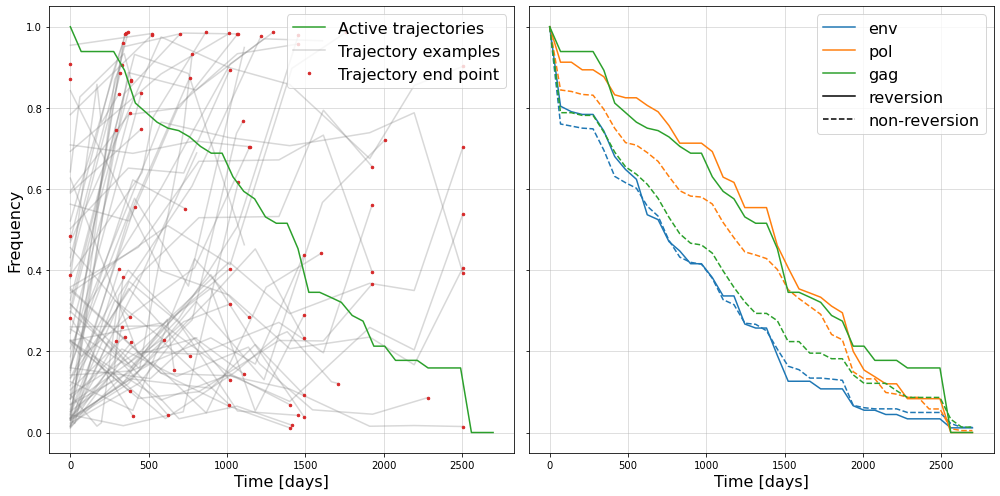

In [9]:
regions = ["env", "pol", "gag"]
colors = ["C0","C1","C2","C7","C3"]
explanation_region = "gag"
explanation_type = "rev"
explanation_color = colors[2]
explanation_marker_size = 5
explanation_traj_alpha = 0.3
grid_alpha = 0.5
fontsize = 16
min_freq = 0.2

time_bins, activities = make_activity_dict(trajectories, 0.15)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,7), sharey=True)

# Explanation plot
for traj in trajectories[explanation_region][explanation_type]:
    if np.sum(traj.frequencies>min_freq, dtype=bool):
        line_traj, = axs[0].plot(traj.t, traj.frequencies, '-', color=colors[3], alpha=explanation_traj_alpha)
for traj in trajectories[explanation_region][explanation_type]:
    if np.sum(traj.frequencies>min_freq, dtype=bool):
        markers, = axs[0].plot(traj.t[-1], traj.frequencies[-1], '.', color=colors[4], markersize=explanation_marker_size)
line_average, = axs[0].plot(time_bins, activities[explanation_region][explanation_type]["active"], '-', color=explanation_color)
axs[0].legend([line_average, line_traj, markers], ["Active trajectories","Trajectory examples", "Trajectory end point"], loc="upper right", fontsize=fontsize)
axs[0].grid(alpha=grid_alpha)
axs[0].set_xlabel("Time [days]", fontsize=fontsize)
axs[0].set_ylabel("Frequency", fontsize=fontsize)

# Activity plot
for ii, region in enumerate(regions):
    axs[1].plot(time_bins, activities[region]["rev"]["active"], '-', color=colors[ii])
    axs[1].plot(time_bins, activities[region]["non_rev"]["active"], '--', color=colors[ii])

line1, = axs[1].plot([0], [0], "k-")
line2, = axs[1].plot([0], [0], "k--")
line3, = axs[1].plot([0], [0], "-", color=colors[0])
line4, = axs[1].plot([0], [0], "-", color=colors[1])
line5, = axs[1].plot([0], [0], "-", color=colors[2])

axs[1].legend([line3, line4, line5, line1, line2], ["env", "pol", "gag", "reversion", "non-reversion"], fontsize=fontsize, loc="upper right")
axs[1].grid(alpha=grid_alpha)
axs[1].set_xlabel("Time [days]", fontsize=fontsize)


plt.tight_layout()
plt.savefig("Multi_activity.png", format="png")
plt.show()